In [1]:
#@Imports
import sys
import os
path = os.path.abspath('..')
if path not in sys.path:
  sys.path.insert(0, path)

%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from retry import retry

from language_models.ollama_logits import OllamaLanguageModel

# from components.components import compute_desire_for_gamble

In [2]:
system_message = ("This is an agent based model. "
  f"The goal of the LLM to to play characters in a game, and act as humanlike as possible. "
  "Ideally, human observers should not be able to tell the difference between the LLM and a human player. "
)

model = OllamaLanguageModel(
"llama3:70b", system_message=system_message, streaming=False
)

In [3]:
@retry(ValueError, tries=5)
def compute_desire_for_gamble(model: OllamaLanguageModel, object: str, query_tokens: list, valence: str = 'positive'):
    """compute value."""
    request = (
        f"You are very logical and rational when doing this task. "
        f"You are presented with a gamble. it has a probability of winning, a value of winning, and a value of losing. "
        f"If you win, you get the win value, if you lose, you get loss value. "
        f"The probability of winning is the 'win_probability'. "
        f"You need to think about an option, and how desirable it is. "
        f"Compute the expected value of the gamble first. "
        f"Think about how good or bad it is and provide a affective feeling preference value between 1 and 10 "
        f"which corresponds to the desirability of the option. "
        f"Use 1 for very {'good' if valence == 'negative' else 'bad'} and 10 for very {'bad' if valence == 'negative' else 'good'}. "
        f"The option is: {object}"
        f"Provide this answer in the form of a number between 1 and 10. "
        f"Provide only a single number as the response."
        f"Do not provide any explanations, just provide a single number."
    )

    output, logits = model.sample_text(request, logits = True, query_tokens=query_tokens)
    return output, logits

In [4]:
@retry(ValueError, tries=5)
def compute_generic_attitude(model: OllamaLanguageModel, object: str, query_tokens: list):
  """Compute attitude for a specific set of objects."""
  request = (
    f"You need to think about an option, and how desirable it is. "
    f"Think about how good or bad it is and provide a affective feeling preference value between 1 and 10 "
    f"which corresponds to the desirability of the option. "
    f"Use 1 for very bad and 10 for very good. "
    f"The option is: {object}"
    f"Provide this answer in the form of a number between 1 and 10. "
    f"Provide only a single number as the response."
    f"Do not provide any explanations, just provide a single number."
  )

  llm_value, logits = model.sample_text(request, logits = True, query_tokens=query_tokens)

  return llm_value, logits

llm_value, logits = compute_generic_attitude(
  model, "Getting a puppy, but having to live in a small apartment.\n", query_tokens = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
)

print(f"Output: {llm_value}. Logits: {logits}")

Output: 7. Logits: {'1': 0, '3': 7.202722862587052e-10, '4': 1.0284314839736908e-06, '5': 3.1244031561072916e-05, '6': 0.6306742429733276, '7': 0.36932572722435, '8': 0.00417734682559967, '9': 1.1723446213807165e-08}


In [5]:
gvs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bvs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pws = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
expected_values = []
attitudes = []
all_logits = []
query_tokens = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
for gv in gvs:
  for bv in bvs:
    for pw in pws:

      # Compute the expected value of the gamble.
      expected_value = pw * gv + (1 - pw) * -1*bv
      gamble_input = f"Probability of Winning (P_w): {pw}, Positive Value on Win (G): {gv}, Negative Value on Loss (B): {-bv}"
      # Compute affective LLM value estimate
      llm_value, logits = compute_desire_for_gamble(model, gamble_input, query_tokens=query_tokens)

      for j in range(10):
        if str(j+1) not in logits.keys():
          logits[str(j+1)] = 0

      all_logits.append(logits)
      expected_values.append(expected_value)
      attitudes.append(llm_value)

In [6]:
attitude_samples = []
for i in range(len(attitudes)):
  p = list(all_logits[i].values())
  p = np.array(p) / sum(p)
  attitude_sample = np.random.choice([int(num) for num in all_logits[i].keys()], p=p, size = 100)
  attitude_samples.append(attitude_sample)

In [21]:
"""Implement basic prospect theory curves based on partial sigmoid curves."""

import numpy as np
import matplotlib.pyplot as plt

def curve_fit(expected_values: list[float], attitudes: list[float]) -> tuple[np.ndarray, np.ndarray]:
  """Fit data with expected values and attitudes towards risky gambles, and return a dictionary of"""
  gains = np.array([expected_value for expected_value, attitude in zip(expected_values, attitudes) if np.greater_equal(expected_value, 0)])
  g_attitude = np.array([attitude for expected_value, attitude in zip(expected_values, attitudes) if np.greater_equal(expected_value, 0)])
  losses = np.array([expected_value for expected_value, attitude in zip(expected_values, attitudes) if np.less(expected_value, 0)])
  l_attitude = np.array([attitude for expected_value, attitude in zip(expected_values, attitudes) if np.less(expected_value, 0)])

  from scipy.optimize import curve_fit

  def sigmoid(x, L ,x0, k, b):
      y = L / (1 + np.exp(-k*(x-x0))) + b
      return (y)

  # Fit for gains
  p0 = [max(g_attitude), np.median(gains),1,min(g_attitude)] # this is an mandatory initial guess
  popt, _ = curve_fit(sigmoid, gains, g_attitude,p0, method='dogbox', maxfev=100000)

  # Fit for losses
  q0 = [max(l_attitude), np.median(losses),1,min(l_attitude)] # this is an mandatory initial guess
  qopt, _ = curve_fit(sigmoid, losses, l_attitude,q0, method='dogbox', maxfev=100000)

  l_x = np.linspace(-100,0,100)
  g_x = np.linspace(0,100,100)


  x = np.concatenate(
     (l_x, g_x)
  )
  curve = np.concatenate(
     (sigmoid(l_x, *qopt),
     sigmoid(g_x, *popt))
  )


  return x, curve

def plot_curve(
    x: np.ndarray,
    curve: np.ndarray,
    expected_values: list[float],
    attitudes: list[float],
    title: str = "Risky Gamble Value Estimates"
) -> None:
  """Plot a prospect theory curve."""
  plt.plot(x, curve, '--k')
  plt.plot(expected_values, attitudes, 'yo')
  plt.xlabel("Expected Value")
  plt.ylabel("Affective Value")
  plt.ylim(0., 10.)
  plt.title(title)
  plt.show()

   

In [22]:
import os
import pandas as pd
import numpy as np

def load_csv(filepath: str | os.PathLike):
  """Load a csv as a dataframe."""
  df = pd.read_csv(filepath)

  all_logits = np.zeros((len(df),10), dtype=float)

  for i in range(10):  
    all_logits[:, i] = df[f'logits_{i+1}'].to_numpy(dtype=float)
  
  evs = df['EV'].to_numpy(dtype=float)
  gvs = df['GV'].to_numpy(dtype=float)
  bvs = df['BV'].to_numpy(dtype=float)
  pws = df['PW'].to_numpy(dtype=int)

  return evs, gvs, bvs, pws, all_logits

In [26]:
evs, gvs, bvs, pws, all_logits = load_csv('./llama3-70b-full-pos.csv')

In [27]:
attitude_samples = []
for i in range(len(all_logits)):
  p = all_logits[i]
  p = np.array(p) / sum(p)
  attitude_sample = np.random.choice([int(num+1) for num in range(len(all_logits[i]))], p=p, size = 100)
  attitude_samples.append(attitude_sample)

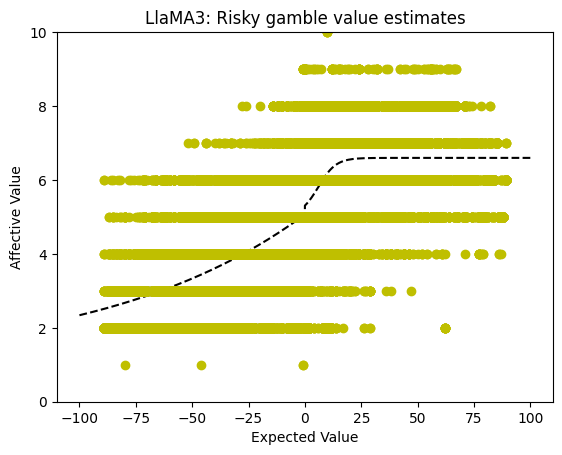

In [28]:
# %autoreload 2



inputs = []
outputs = []
all_gvs = []
all_bvs = []
all_pws = []

for i in range(len(evs)):
  for j in range(len(attitude_samples[i])):
    inputs.append(evs[i])
    outputs.append(attitude_samples[i][j])
    all_gvs.append(gvs[i])
    all_bvs.append(bvs[i])
    all_pws.append(pws[i])

outcomes = curve_fit(inputs, outputs)
plot_curve(*outcomes, inputs, outputs, title = "LlaMA3: Risky gamble value estimates")

In [18]:
import csv

vals = [[bv, gv, pw] for bv in bvs for gv in gvs for pw in pws]

with open('./llama3-70b-full-pos.csv', 'w') as f:

  writer = csv.writer(f)
  writer.writerow(
    ["EV", "BV", "GV", "PW", 
     "logits_1", "logits_2", "logits_3", "logits_4", "logits_5", 
     "logits_6", "logits_7", "logits_8", "logits_9", "logits_10"]
  )
  for i in range(len(attitudes)):
    p = list(all_logits[i].values())
    p = np.array(p) / sum(p)
    writer.writerow(
      [expected_values[i], vals[i][0], vals[i][1], vals[i][2], *p] 
    )

In [19]:
gvs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bvs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pws = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
expected_values = []
attitudes = []
all_logits = []
query_tokens = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
for gv in gvs:
  for bv in bvs:
    for pw in pws:

      # Compute the expected value of the gamble.
      expected_value = pw * gv + (1 - pw) * -1*bv
      gamble_input = f"Probability of Winning (P_w): {pw}, Positive Value on Win (G): {gv}, Negative Value on Loss (B): {-bv}"
      # Compute affective LLM value estimate
      llm_value, logits = compute_desire_for_gamble(model, gamble_input, query_tokens=query_tokens, valence = "negative")

      for j in range(10):
        if str(j+1) not in logits.keys():
          logits[str(j+1)] = 0

      all_logits.append(logits)
      expected_values.append(expected_value)
      attitudes.append(llm_value)

In [20]:
import csv

vals = [[bv, gv, pw] for bv in bvs for gv in gvs for pw in pws]

with open('./llama3-70b-full-neg.csv', 'w') as f:

  writer = csv.writer(f)
  writer.writerow(
    ["EV", "BV", "GV", "PW", 
     "logits_1", "logits_2", "logits_3", "logits_4", "logits_5", 
     "logits_6", "logits_7", "logits_8", "logits_9", "logits_10"]
  )
  for i in range(len(attitudes)):
    p = list(all_logits[i].values())
    p = np.array(p) / sum(p)
    writer.writerow(
      [expected_values[i], vals[i][0], vals[i][1], vals[i][2], *p] 
    )